# Input prompt feature extraction

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter

import spacy 
import textstat

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
#from sklearn.svm import SVC


#import shap
import matplotlib.pyplot as plt

## I) Data Loading

In [2]:
generation_file = 'dataset/generation.jsonl'
eval_result = 'dataset/eval_results.json'


generation_df = pd.read_json(generation_file, lines=True)
evaluation_df = pd.read_json(eval_result)

In [3]:
generation_df

,title,h_score_cat,pageid,revid,description,categories,reference,prompt,answer,generation
0,Japanese sleeper ray,0,32237617,1100445892,Species of cartilaginous fish,"[Fish described in 1850, Fish of Japan, Fish o...",The Japanese sleeper ray (Narke japonica) is a...,What is the IUCN conservation status of the Ja...,Vulnerable,The Japanese sleeper ray (Narke japonica) is l...
1,The Terrorists of Iraq,0,54263323,1173155771,2014 book by Malcolm Nance,"[2007 non-fiction books, 2014 non-fiction book...",The Terrorists of Iraq: Inside the Strategy an...,"Who is the author of ""The Terrorists of Iraq: ...",Malcolm Nance,"The author of ""The Terrorists of Iraq: Inside ..."
2,Ernie Cooksey,0,11042846,1164016159,British footballer (1980–2008),"[1980 births, 2008 deaths, Bishop's Stortford ...",## Personal life and illness\n\nBefore joining...,What type of cancer was Ernie Cooksey diagnose...,Malignant melanoma,Ernie Cooksey was diagnosed with malignant mel...
3,"St Mary's Church, Rolleston on Dove",0,64011419,1125594842,None,"[12th-century church buildings in England, Art...",## Current structure\n\nThe current church dat...,Who was the architect responsible for the majo...,Sir Arthur Blomfield,The architect responsible for the major restor...
4,SMS Moltke (1877),0,10518787,1163788924,Screw corvette of the German Imperial Navy,"[1877 ships, Bismarck-class corvettes, Ships b...",Moltke took Kaiserin Friedrich aboard and tran...,What was the destination when SMS Moltke trans...,Venice,"From 16 to 18 April 1891, the SMS Moltke trans..."
5,Music of Final Fantasy X,1,1337053,1164450454,Music from the video game Final Fantasy X,"[Final Fantasy X, Final Fantasy music, Video g...",### Final Fantasy X Vocal Collection\n\nFinal ...,What is the catalog number of the Final Fantas...,SSCX-10073,"The catalog number for the ""Final Fantasy X Vo..."
6,Duke of Marmalade,1,19031071,1148477842,Irish-bred Thoroughbred racehorse,"[2004 racehorse births, 2021 racehorse deaths,...",#### Summer In the Prince of Wales's Stakes at...,"Who was described as the ""Iron Duke"" in the pr...",Duke of Marmalade,"The ""Iron Duke"" was a nickname often used for ..."
7,Auld Lang Syne (The New Year's Anthem),1,30127340,1169772511,None,"[2010 singles, 2010 songs, Dance-pop songs, El...","## Background and composition\n\n""Auld Lang Sy...","What is the duration of Mariah Carey's ""Auld L...",Three minutes and forty-seven seconds.,"Mariah Carey's ""Auld Lang Syne (The New Year's..."
8,Bergen Air Transport,1,1821374,1054448380,Former Norwegian airline,"[2017 disestablishments in Norway, Airlines di...",## History Bergen Air Transport was founded in...,What year did Bergen Air Transport cease all o...,2017,Bergen Air Transport ceased all operative serv...
9,The Secret of the Nagas,1,32230799,1164510307,2011 novel by Amish Tripathi,"[2011 Indian novels, 2011 fantasy novels, Hind...",### Characters - Shiva – The main character in...,What potion does Shiva consume that turns his ...,Somras,"In Hindu mythology, Lord Shiva consumes the Ha..."


In [4]:
evaluation_df

,model,halu_Rate,refusal_rate,correct_rate,evaluator_abstantion,evaluator_hallucination,abstantion,halu_test_res,abstantion_raw_generation,is_hallucinated_raw_generation
0,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,True,"{""is_abstaining"":false}",No
1,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,False,"{""is_abstaining"":false}",Yes
2,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,False,"{""is_abstaining"":false}",Yes
3,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,True,"{""is_abstaining"":false}",No
4,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,False,"{""is_abstaining"":false}",Yes
5,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,True,"{""is_abstaining"":false}",No
6,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,True,"{""is_abstaining"":false}",No
7,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,True,"{""is_abstaining"":false}",
8,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,False,"{""is_abstaining"":false}",Yes
9,gpt-4o,0.366667,0,0.633333,gpt-5,gpt-5,False,True,"{""is_abstaining"":false}",No


## II) Spacy Analysis

In [5]:
prompt_df = generation_df[['prompt']]
nlp = spacy.load("en_core_web_sm")

prompt_df

,prompt
0,What is the IUCN conservation status of the Ja...
1,"Who is the author of ""The Terrorists of Iraq: ..."
2,What type of cancer was Ernie Cooksey diagnose...
3,Who was the architect responsible for the majo...
4,What was the destination when SMS Moltke trans...
5,What is the catalog number of the Final Fantas...
6,"Who was described as the ""Iron Duke"" in the pr..."
7,"What is the duration of Mariah Carey's ""Auld L..."
8,What year did Bergen Air Transport cease all o...
9,What potion does Shiva consume that turns his ...


In [6]:
def spacy_feature(doc):
    
    # ------------- token filter ------------- 
    non_punct_token = [t for t in doc if not t.is_punct and not t.is_space]                 #Token that are not punctuation or space
    words = [t for t in non_punct_token if t.is_alpha]                                      #Token that are alphabetic words
    lemma = [t.lemma_.lower() for t in words]                                               #Lemma words: normalized form of a word
    
    # ------------- bacic count ------------- 
    num_sents = sum(1 for _ in doc.sents)                                                   #Number of sentence
    num_token = len(doc)                                                                    #Number of tokens
    
    # ------------- Richess vocabulary ------------- 
    lemma_counts = Counter(lemma)
    lemma_ratio = len(lemma_counts) / num_token                                             #Lemma ratio
    
    # ------------- POS ratios ------------- 
    pos = Counter(t.pos_ for t in doc)
    noun_ratio = pos["NOUN"] / len(doc)
    verb_ratio = pos["VERB"] / len(doc)
    adj_ratio = pos["ADJ"] / len(doc)
    adv_ratio = pos["ADV"] / len(doc)
    aux_ratio = pos['AUX'] / len(doc)

    # ------------- Punctuations -------------    
    stop_ratio = np.mean([t.is_stop for t in doc]) if len(doc) else 0.0                     #Ratio stop words in the sentence  
    punct_ratio = np.mean([t.is_punct for t in doc]) if len(doc) else 0.0                   #Ratio punctuation in the sentence  
    
    # ------------- Recognized entity ------------- 
    entity_count = len(doc.ents)
    entity_ratio = entity_count / len(doc)                                                  #Ratio recognized entity in the sentence
    
    features = {
        'number sentence' : num_sents,
        'lemma ratio' : lemma_ratio, 
        'noun ratio' : noun_ratio, 
        'verb ratio' : verb_ratio, 
        'adjective ratio' : adj_ratio, 
        'adverb ratio' : adv_ratio, 
        'auxiliairis ratio' : aux_ratio, 
        'stop ratio' : stop_ratio, 
        'punctuation ratio' : punct_ratio, 
        'entity ratio' : entity_ratio}
    
    return features

In [7]:
docs = nlp.pipe(prompt_df["prompt"].tolist())

spacy_features_df = [spacy_feature(doc) for doc in docs]
features_df = pd.DataFrame(spacy_features_df)
df_with_spacy_features = pd.concat([prompt_df.reset_index(drop=True), features_df], axis=1)


df_with_spacy_features

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio
0,What is the IUCN conservation status of the Ja...,1,0.833333,0.250000,0.000000,0.166667,0.000000,0.083333,0.416667,0.083333,0.166667
1,"Who is the author of ""The Terrorists of Iraq: ...",1,0.521739,0.043478,0.000000,0.000000,0.000000,0.043478,0.434783,0.173913,0.043478
2,What type of cancer was Ernie Cooksey diagnose...,1,0.846154,0.153846,0.076923,0.076923,0.000000,0.076923,0.384615,0.076923,0.076923
3,Who was the architect responsible for the majo...,1,0.761905,0.095238,0.000000,0.095238,0.000000,0.047619,0.428571,0.095238,0.142857
4,What was the destination when SMS Moltke trans...,1,0.812500,0.062500,0.062500,0.000000,0.000000,0.062500,0.375000,0.062500,0.187500
5,What is the catalog number of the Final Fantas...,1,0.857143,0.214286,0.000000,0.000000,0.000000,0.071429,0.357143,0.071429,0.071429
6,"Who was described as the ""Iron Duke"" in the pr...",1,0.705882,0.058824,0.117647,0.000000,0.000000,0.058824,0.411765,0.176471,0.117647
7,"What is the duration of Mariah Carey's ""Auld L...",1,0.619048,0.047619,0.000000,0.000000,0.000000,0.047619,0.333333,0.238095,0.190476
8,What year did Bergen Air Transport cease all o...,1,0.909091,0.181818,0.090909,0.090909,0.000000,0.090909,0.272727,0.090909,0.090909
9,What potion does Shiva consume that turns his ...,1,0.882353,0.117647,0.176471,0.058824,0.000000,0.058824,0.411765,0.117647,0.058824


## III) TextStat Analysis

In [8]:
def textstat_feature(doc):
    # ------------- Readibility ------------- 
    flesch_score = textstat.flesch_reading_ease(doc)                        #flesh score
    us_school_grade = textstat.flesch_kincaid_grade(doc)                    #US School grade level  
    complexity = textstat.gunning_fog(doc)                                  #Complexity of the sentence
    
    # ------------- Words difficulty ------------- 
    nb_rare_words = textstat.difficult_words(doc)                           #Number difficulties words
    dale_chall_score = textstat.dale_chall_readability_score(doc)           #Dale CHall Score
    
    features = {
        'flesch score' : flesch_score,
        'grade (US School)' : us_school_grade,
        'complexity' : complexity,
        'Number rare words' : nb_rare_words,
        'Dale-Chall Score' : dale_chall_score
    }
    
    return features

In [9]:
docs = prompt_df["prompt"].tolist()

textstat_features_df = [textstat_feature(doc) for doc in docs]


textstat_features_df = pd.DataFrame(textstat_features_df)
df_with_textstat_features = pd.concat([df_with_spacy_features.reset_index(drop=True), textstat_features_df], axis=1)


df_with_textstat_features 

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score
0,What is the IUCN conservation status of the Ja...,1,0.833333,0.250000,0.000000,0.166667,0.000000,0.083333,0.416667,0.083333,0.166667,57.233636,8.009091,11.672727,4,11.359373
1,"Who is the author of ""The Terrorists of Iraq: ...",1,0.521739,0.043478,0.000000,0.000000,0.000000,0.043478,0.434783,0.173913,0.043478,49.518421,11.072632,13.915789,5,10.396268
2,What type of cancer was Ernie Cooksey diagnose...,1,0.846154,0.153846,0.076923,0.076923,0.000000,0.076923,0.384615,0.076923,0.076923,67.755000,6.790000,8.133333,4,12.126700
3,Who was the architect responsible for the majo...,1,0.761905,0.095238,0.000000,0.095238,0.000000,0.047619,0.428571,0.095238,0.142857,52.265000,10.441111,13.866667,5,10.669856
4,What was the destination when SMS Moltke trans...,1,0.812500,0.062500,0.062500,0.000000,0.000000,0.062500,0.375000,0.062500,0.187500,67.530000,7.566667,11.333333,3,12.801833
5,What is the catalog number of the Final Fantas...,1,0.857143,0.214286,0.000000,0.000000,0.000000,0.071429,0.357143,0.071429,0.071429,43.963077,10.356923,14.430769,6,12.783608
6,"Who was described as the ""Iron Duke"" in the pr...",1,0.705882,0.058824,0.117647,0.000000,0.000000,0.058824,0.411765,0.176471,0.117647,59.682143,8.412857,8.457143,2,9.970186
7,"What is the duration of Mariah Carey's ""Auld L...",1,0.619048,0.047619,0.000000,0.000000,0.000000,0.047619,0.333333,0.238095,0.190476,71.767857,6.727143,11.314286,4,13.353757
8,What year did Bergen Air Transport cease all o...,1,0.909091,0.181818,0.090909,0.090909,0.000000,0.090909,0.272727,0.090909,0.090909,52.865000,8.370000,12.000000,4,12.027500
9,What potion does Shiva consume that turns his ...,1,0.882353,0.117647,0.176471,0.058824,0.000000,0.058824,0.411765,0.117647,0.058824,78.810000,5.993333,6.000000,5,10.696500


## IV) Sentiment Analysis

In [10]:
def sentiment_analysis_feature(doc):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    features = sentiment_analyzer.polarity_scores(doc)
    
    rename_feature = {
        'negative sentiment' : features['neg'],
        'neutral sentiment' : features['neu'],
        'positive sentiment' : features['pos'],
        'overall sentiment' : features['compound']
    }
    return rename_feature

In [11]:
docs = prompt_df["prompt"].tolist()

sentiments_features_df = [sentiment_analysis_feature(doc) for doc in docs]


sentiments_features_df = pd.DataFrame(sentiments_features_df)
df_with_sentiment_features = pd.concat([df_with_textstat_features .reset_index(drop=True), sentiments_features_df], axis=1)


df_with_sentiment_features

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score,negative sentiment,neutral sentiment,positive sentiment,overall sentiment
0,What is the IUCN conservation status of the Ja...,1,0.833333,0.250000,0.000000,0.166667,0.000000,0.083333,0.416667,0.083333,0.166667,57.233636,8.009091,11.672727,4,11.359373,0.000,1.000,0.000,0.0000
1,"Who is the author of ""The Terrorists of Iraq: ...",1,0.521739,0.043478,0.000000,0.000000,0.000000,0.043478,0.434783,0.173913,0.043478,49.518421,11.072632,13.915789,5,10.396268,0.186,0.814,0.000,-0.6249
2,What type of cancer was Ernie Cooksey diagnose...,1,0.846154,0.153846,0.076923,0.076923,0.000000,0.076923,0.384615,0.076923,0.076923,67.755000,6.790000,8.133333,4,12.126700,0.286,0.714,0.000,-0.6597
3,Who was the architect responsible for the majo...,1,0.761905,0.095238,0.000000,0.095238,0.000000,0.047619,0.428571,0.095238,0.142857,52.265000,10.441111,13.866667,5,10.669856,0.000,0.881,0.119,0.3182
4,What was the destination when SMS Moltke trans...,1,0.812500,0.062500,0.062500,0.000000,0.000000,0.062500,0.375000,0.062500,0.187500,67.530000,7.566667,11.333333,3,12.801833,0.000,1.000,0.000,0.0000
5,What is the catalog number of the Final Fantas...,1,0.857143,0.214286,0.000000,0.000000,0.000000,0.071429,0.357143,0.071429,0.071429,43.963077,10.356923,14.430769,6,12.783608,0.000,0.902,0.098,0.0772
6,"Who was described as the ""Iron Duke"" in the pr...",1,0.705882,0.058824,0.117647,0.000000,0.000000,0.058824,0.411765,0.176471,0.117647,59.682143,8.412857,8.457143,2,9.970186,0.000,1.000,0.000,0.0000
7,"What is the duration of Mariah Carey's ""Auld L...",1,0.619048,0.047619,0.000000,0.000000,0.000000,0.047619,0.333333,0.238095,0.190476,71.767857,6.727143,11.314286,4,13.353757,0.000,1.000,0.000,0.0000
8,What year did Bergen Air Transport cease all o...,1,0.909091,0.181818,0.090909,0.090909,0.000000,0.090909,0.272727,0.090909,0.090909,52.865000,8.370000,12.000000,4,12.027500,0.000,1.000,0.000,0.0000
9,What potion does Shiva consume that turns his ...,1,0.882353,0.117647,0.176471,0.058824,0.000000,0.058824,0.411765,0.117647,0.058824,78.810000,5.993333,6.000000,5,10.696500,0.000,1.000,0.000,0.0000


## V) Hallucination output

In [12]:
hallucination_output = evaluation_df['halu_test_res'].astype(int)
hallucination_output

0     1
1     0
2     0
3     1
4     0
5     1
6     1
7     1
8     0
9     1
10    0
11    0
12    1
13    0
14    1
15    0
16    1
17    0
18    0
19    0
20    0
21    1
22    0
23    0
24    0
25    0
26    1
27    0
28    0
29    0
Name: halu_test_res, dtype: int64

In [13]:
input_df = pd.concat([df_with_sentiment_features.reset_index(drop=True), hallucination_output], axis=1)
input_df

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,...,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score,negative sentiment,neutral sentiment,positive sentiment,overall sentiment,halu_test_res
0,What is the IUCN conservation status of the Ja...,1,0.833333,0.250000,0.000000,0.166667,0.000000,0.083333,0.416667,0.083333,...,57.233636,8.009091,11.672727,4,11.359373,0.000,1.000,0.000,0.0000,1
1,"Who is the author of ""The Terrorists of Iraq: ...",1,0.521739,0.043478,0.000000,0.000000,0.000000,0.043478,0.434783,0.173913,...,49.518421,11.072632,13.915789,5,10.396268,0.186,0.814,0.000,-0.6249,0
2,What type of cancer was Ernie Cooksey diagnose...,1,0.846154,0.153846,0.076923,0.076923,0.000000,0.076923,0.384615,0.076923,...,67.755000,6.790000,8.133333,4,12.126700,0.286,0.714,0.000,-0.6597,0
3,Who was the architect responsible for the majo...,1,0.761905,0.095238,0.000000,0.095238,0.000000,0.047619,0.428571,0.095238,...,52.265000,10.441111,13.866667,5,10.669856,0.000,0.881,0.119,0.3182,1
4,What was the destination when SMS Moltke trans...,1,0.812500,0.062500,0.062500,0.000000,0.000000,0.062500,0.375000,0.062500,...,67.530000,7.566667,11.333333,3,12.801833,0.000,1.000,0.000,0.0000,0
5,What is the catalog number of the Final Fantas...,1,0.857143,0.214286,0.000000,0.000000,0.000000,0.071429,0.357143,0.071429,...,43.963077,10.356923,14.430769,6,12.783608,0.000,0.902,0.098,0.0772,1
6,"Who was described as the ""Iron Duke"" in the pr...",1,0.705882,0.058824,0.117647,0.000000,0.000000,0.058824,0.411765,0.176471,...,59.682143,8.412857,8.457143,2,9.970186,0.000,1.000,0.000,0.0000,1
7,"What is the duration of Mariah Carey's ""Auld L...",1,0.619048,0.047619,0.000000,0.000000,0.000000,0.047619,0.333333,0.238095,...,71.767857,6.727143,11.314286,4,13.353757,0.000,1.000,0.000,0.0000,1
8,What year did Bergen Air Transport cease all o...,1,0.909091,0.181818,0.090909,0.090909,0.000000,0.090909,0.272727,0.090909,...,52.865000,8.370000,12.000000,4,12.027500,0.000,1.000,0.000,0.0000,0
9,What potion does Shiva consume that turns his ...,1,0.882353,0.117647,0.176471,0.058824,0.000000,0.058824,0.411765,0.117647,...,78.810000,5.993333,6.000000,5,10.696500,0.000,1.000,0.000,0.0000,1


In [14]:
input_df.to_excel('dataset/inputdata_hallucination.xlsx')

In [15]:
input_df = input_df.drop(columns={'prompt'})
input_df = input_df.rename(columns={'halu_test_res' : 'hallucination score'})
input_df

,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score,negative sentiment,neutral sentiment,positive sentiment,overall sentiment,hallucination score
0,1,0.833333,0.250000,0.000000,0.166667,0.000000,0.083333,0.416667,0.083333,0.166667,57.233636,8.009091,11.672727,4,11.359373,0.000,1.000,0.000,0.0000,1
1,1,0.521739,0.043478,0.000000,0.000000,0.000000,0.043478,0.434783,0.173913,0.043478,49.518421,11.072632,13.915789,5,10.396268,0.186,0.814,0.000,-0.6249,0
2,1,0.846154,0.153846,0.076923,0.076923,0.000000,0.076923,0.384615,0.076923,0.076923,67.755000,6.790000,8.133333,4,12.126700,0.286,0.714,0.000,-0.6597,0
3,1,0.761905,0.095238,0.000000,0.095238,0.000000,0.047619,0.428571,0.095238,0.142857,52.265000,10.441111,13.866667,5,10.669856,0.000,0.881,0.119,0.3182,1
4,1,0.812500,0.062500,0.062500,0.000000,0.000000,0.062500,0.375000,0.062500,0.187500,67.530000,7.566667,11.333333,3,12.801833,0.000,1.000,0.000,0.0000,0
5,1,0.857143,0.214286,0.000000,0.000000,0.000000,0.071429,0.357143,0.071429,0.071429,43.963077,10.356923,14.430769,6,12.783608,0.000,0.902,0.098,0.0772,1
6,1,0.705882,0.058824,0.117647,0.000000,0.000000,0.058824,0.411765,0.176471,0.117647,59.682143,8.412857,8.457143,2,9.970186,0.000,1.000,0.000,0.0000,1
7,1,0.619048,0.047619,0.000000,0.000000,0.000000,0.047619,0.333333,0.238095,0.190476,71.767857,6.727143,11.314286,4,13.353757,0.000,1.000,0.000,0.0000,1
8,1,0.909091,0.181818,0.090909,0.090909,0.000000,0.090909,0.272727,0.090909,0.090909,52.865000,8.370000,12.000000,4,12.027500,0.000,1.000,0.000,0.0000,0
9,1,0.882353,0.117647,0.176471,0.058824,0.000000,0.058824,0.411765,0.117647,0.058824,78.810000,5.993333,6.000000,5,10.696500,0.000,1.000,0.000,0.0000,1


## VI) Logistic regression

In [16]:
X = input_df.drop(columns={'hallucination score'})
y = input_df['hallucination score']

model_logistic_regression = LogisticRegression(max_iter = 10000)
model_logistic_regression.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [17]:
importance_logistic_regression = pd.Series(model_logistic_regression.coef_[0], index=X.columns).sort_values(ascending=False)
importance_logistic_regression 

neutral sentiment     0.706747
Number rare words     0.352248
stop ratio            0.280881
grade (US School)     0.278669
overall sentiment     0.236695
noun ratio            0.226840
auxiliairis ratio     0.072006
flesch score          0.046155
lemma ratio           0.042652
entity ratio          0.040964
adjective ratio       0.024013
adverb ratio          0.008265
number sentence       0.000407
verb ratio           -0.038954
Dale-Chall Score     -0.092448
complexity           -0.124509
punctuation ratio    -0.151851
negative sentiment   -0.337973
positive sentiment   -0.368366
dtype: float64

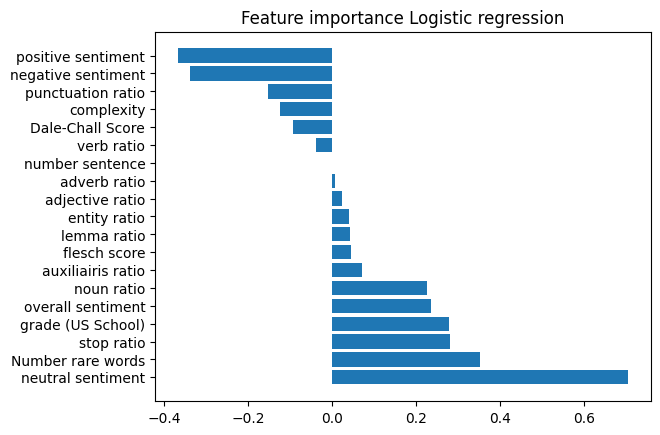

In [18]:
plt.figure()
plt.barh(importance_logistic_regression.index, importance_logistic_regression.values)
plt.title('Feature importance Logistic regression')
plt.show()

## VII) Correlation matrix

In [19]:
corr_matrix = input_df.corr()  
corr_matrix = corr_matrix['hallucination score']
corr_matrix = corr_matrix.drop(['hallucination score', 'number sentence'])
corr_matrix = corr_matrix.sort_values(ascending=False)
corr_matrix

neutral sentiment     0.402610
stop ratio            0.285265
noun ratio            0.277235
auxiliairis ratio     0.187440
Number rare words     0.110401
entity ratio          0.074004
adjective ratio       0.069667
overall sentiment     0.068865
lemma ratio           0.037080
flesch score          0.036263
adverb ratio          0.033963
grade (US School)     0.019590
complexity           -0.073708
verb ratio           -0.086008
Dale-Chall Score     -0.097578
positive sentiment   -0.244893
punctuation ratio    -0.269932
negative sentiment   -0.327695
Name: hallucination score, dtype: float64

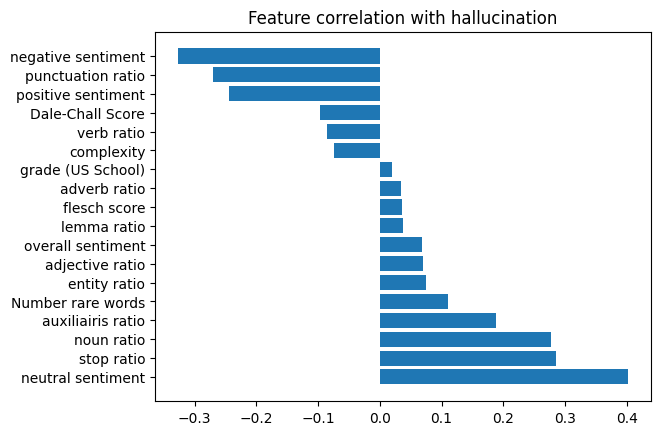

In [20]:
plt.figure()
plt.barh(corr_matrix.index, corr_matrix.values)
plt.title('Feature correlation with hallucination')
plt.show()

## VIII) Mutual Information

In [21]:
mi = mutual_info_classif(X, y)
mi_df = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi_df

adjective ratio       0.184580
neutral sentiment     0.117662
positive sentiment    0.093892
overall sentiment     0.088323
adverb ratio          0.042556
stop ratio            0.041776
auxiliairis ratio     0.029050
negative sentiment    0.015638
noun ratio            0.000000
number sentence       0.000000
lemma ratio           0.000000
flesch score          0.000000
entity ratio          0.000000
punctuation ratio     0.000000
verb ratio            0.000000
Dale-Chall Score      0.000000
Number rare words     0.000000
complexity            0.000000
grade (US School)     0.000000
dtype: float64

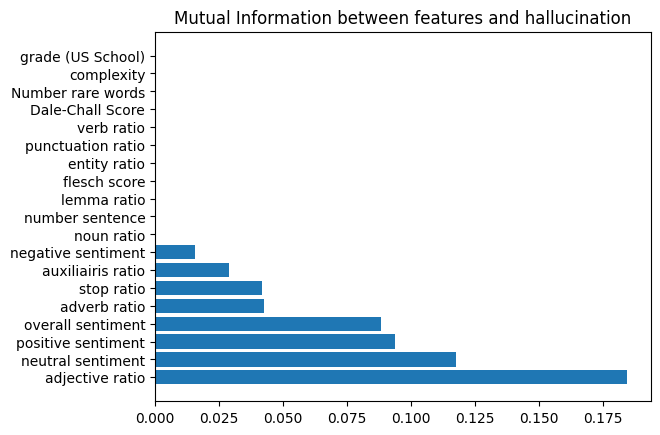

In [22]:
plt.figure()
plt.barh(mi_df.index, mi_df.values)
plt.title('Mutual Information between features and hallucination')
plt.show()